   # Muon decay experiment

We use this code to:
* simulate the muon decay experiment,
* obtain a best fit value for the lifetime, and 
* the corresponding error using Monte Carlo methods.

In [21]:
%matplotlib notebook

from __future__ import division    #for division operator
import numpy as np
from scipy.optimize import minimize, curve_fit
import scipy.stats as stats
from pynverse import inversefunc
import matplotlib.pylab as plt
outfilepath = '/Users/Jatan/Google Drive/PHYS2010/Muon_decay/'   #modify this path to your plot directory

We first simulate the muon data set using Monte carlo methods. Initializing,

In [32]:
sig_samples = 1500
bkg_samples = 600
start_t = 0
stop_t = 20 #micro seconds
bw = 0.01 #10 ns
data_bins = np.arange(0, stop_t + bw, bw)
tau = 2.2 # microseconds
def exp_func(t, lifetime):
 	return (0.714/(lifetime*(1 - np.exp(-stop_t/lifetime))))*np.exp(-t/lifetime) + (0.286/20)

## Method 1: Rejection sampling

1800 samples were generated using rejection sampling. Also shown is a histogram of events per 0.5 $\mu s$ bins for reference. 

7


<IPython.core.display.Javascript object>


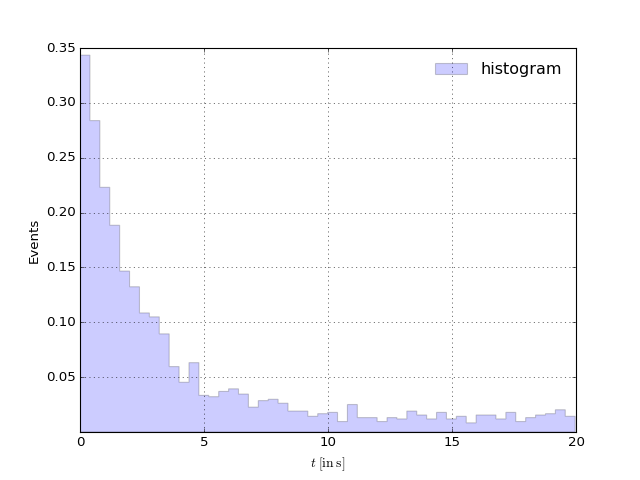

In [52]:
signal = []
count = 1
count_tot = 1

while count <= (sig_samples+bkg_samples):
	count_tot += 1
	x = stop_t*np.random.random()
	y = np.random.random()
	if y <= exp_func(x, tau):
		signal.append(x)
		count += 1

events, bins = np.histogram(signal, data_bins) 
rescaled_bins = (bins[:-1] + bins[1:]) / 2  #rescaling bins to find midpoints for each bin

print events[0]

fig, ax = plt.subplots(1, 1)
plt.hist(signal, 50, normed='True', histtype='stepfilled', color='blue', alpha=0.2, label='histogram')
plt.xlim(0, 20)
plt.xlabel(r'$t \; [ \mathrm{in \; s} ]$')
plt.ylim(0, 0.35)
plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.ylabel(r'Events')
plt.legend(loc='upper right', frameon=False)
plt.grid()
plt.show()

As there is data available in every bin, we can minimize the chi-squared statistic to obtain best fit parameters ($\,A, \tau$ and $B\,$) for the function,
\begin{equation}
f_\text{fit}(t) = A\,e^{\,(\frac{-t}{\tau})} \, + \, B
\end{equation}

where the chi-squared statistic is calculated the usual way,
\begin{equation}
\chi^2  = \sum_{i=1}^{N} \, \frac{(\, y_i - f_\text{fit}(t_i)\,)^2}{\sigma^2_{\text{th},\, i}}
\end{equation}

We use $\sigma_{\text{th},\, i} = \sqrt{f_\text{fit}(t_i)}$ instead of the experimental error to prevent the value of $\chi^2$ from diverging for bins with no/very few events.

In [53]:
init_params_chisq = [1, 1, 1]
def func_chisq(params):    
	A, lifetime, B = params
	return np.sum([pow((events[i] - (A*np.exp(-rescaled_bins[i]/lifetime) + B)), 2)/(A*np.exp(-rescaled_bins[i]/lifetime) + B) for i in range(len(events))])
fit_param = minimize(func_chisq, init_params_chisq, method='nelder-mead')
print fit_param.x

chi_sq = func_chisq(fit_param.x)
print chi_sq #/(len(rescaled_bins)-3) for chi_sq/dof

[ 7.42865364  2.14190264  0.62008802]
1463.579367


<IPython.core.display.Javascript object>


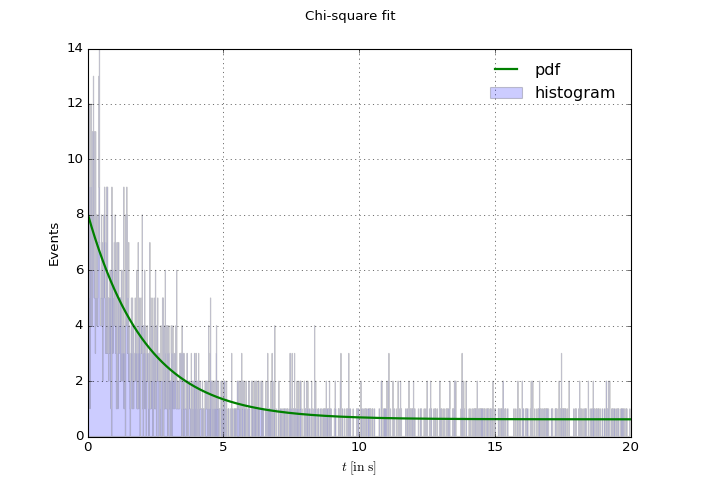

In [56]:
result_bestfit = [(fit_param.x[0]*np.exp(-rescaled_bins[i]/fit_param.x[1]) + fit_param.x[2]) for i in range(len(events))]
fig, ax = plt.subplots(1, 1)
plt.hist(signal, len(rescaled_bins), histtype='stepfilled', color='blue', alpha=0.2, label='histogram')
plt.plot(rescaled_bins, result_bestfit, color='g', lw=2, label='pdf')
plt.xlim(0, 20)
plt.xlabel(r'$t \; [ \mathrm{in \ s} ]$')
plt.ylabel(r'Events')
plt.suptitle('Chi-square fit')
plt.legend(loc='upper right', frameon=False)
plt.grid()
plt.savefig(outfilepath + 'chisq_fit.pdf')

To avoid binning errors, we perform an unbinned maximum likelihood fit on the data. Since the signal for the muon decay is given by:
\begin{equation}
N(t) = N_\text{sig} \, e^{\,(\frac{-t}{\tau})} + N_\text{bkg}
\end{equation}

it's preferable to use an exponential pdf for the fit. The normalized pdf we consider is
\begin{equation}
f(x) = A\,e^{\,(\frac{-t}{\tau})} + B
\end{equation}
where
\begin{equation}
A = \frac{0.7}{\tau\,(1 - e^{\,(\frac{-20}{\tau})})}, \;\;\;
B = \frac{0.286}{20}
\end{equation}

We can define the likelihood function as
\begin{equation}
\mathcal{L}\,(\tau \,|\, t_i) = \prod_{i=1}^{N} \left( A \, e^{\,(\frac{-t_i}{\tau})} + B \right)
\end{equation}

Or equivalently the log likelihood,
\begin{equation}
\log \mathcal{L}\,(t_i \,|\, \tau) = \sum_{i=1}^{N} \log \left( A\,e^{\,(\frac{-t_i}{\tau})} + B\right)
\end{equation}

We maximize the log likelihood to obtain the best fit lifetime $\tau$ and the maximum likelihood value.

In [26]:
def likelihood_fit(params):
	lifetime = params
	logll = np.sum([np.log((0.714/(lifetime*(1 - np.exp(-20/lifetime))))*np.exp(-signal[i]/lifetime) + (0.286/20)) for i in range(len(signal))])
	return -logll

init_params = [1,]
result = minimize(likelihood_fit, init_params, method='nelder-mead')
tau_fit = result.x[0]   #best fit estimator = np.sum(signal)/len(signal)

print likelihood_fit(tau_fit), tau_fit

4981.4079094 2.17705078125


<IPython.core.display.Javascript object>


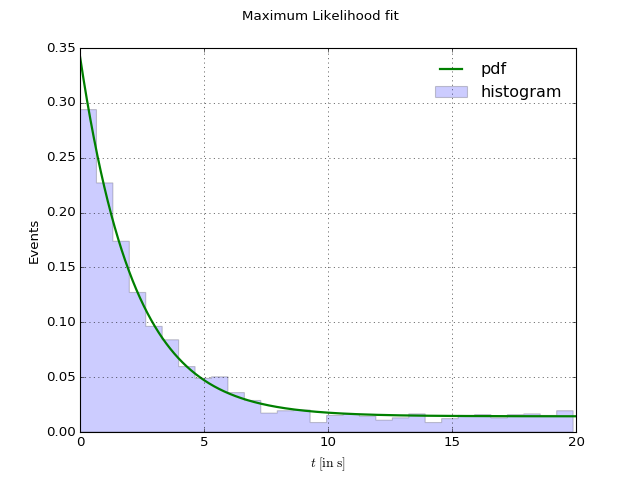

In [27]:
fig, ax = plt.subplots(1, 1)
plt.hist(signal, 30, normed='True', histtype='stepfilled', color='blue', alpha=0.2, label='histogram')
plt.plot(data_bins, exp_func(data_bins, tau_fit), color='g', lw='2', label='pdf')
plt.xlim(0, 20)
plt.xlabel(r'$t \; [ \mathrm{in \ s} ]$')
#plt.ylim(0, 300)
#plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.ylabel(r'Events')
plt.suptitle('Maximum Likelihood fit')
plt.legend(loc='upper right', frameon=False)
plt.grid()
plt.savefig(outfilepath + 'ml_fit.pdf')

To estimate the error in the lifetime parameter $\tau$, we generate $10^3$ 'copies' of our experiment and calculate the standard error in the best fit values obtained for each copy.

In [28]:
tau_fit = []
likhood = []
no_of_samples = 1000
for i in range(no_of_samples):

	signal = []
	count = 1
	count_tot = 1
	while count <= (sig_samples+bkg_samples):
		count_tot += 1
		x = stop_t*np.random.random()
		y = np.random.random()
		if y <= exp_func(x, tau):
			signal.append(x)
			count += 1


#perform likelihood fit to data
	def likelihood_fit(params):
		lifetime = params
		logll = np.sum([np.log((0.714/(lifetime*(1 - np.exp(-stop_t/lifetime))))*np.exp(-signal[i]/lifetime) + (0.286/20)) for i in range(len(signal))])
		return -logll
    
	init_params = [1,]
	result = minimize(likelihood_fit, init_params, method='nelder-mead')
	tau_fit.append(result.x[0])   
	likhood.append(-likelihood_fit(result.x[0]))    

print np.average(tau_fit), np.sqrt(np.var(tau_fit)/len(tau_fit))  #mean and variance in lifetime calculation

2.19739169922 0.00243410500107


<IPython.core.display.Javascript object>


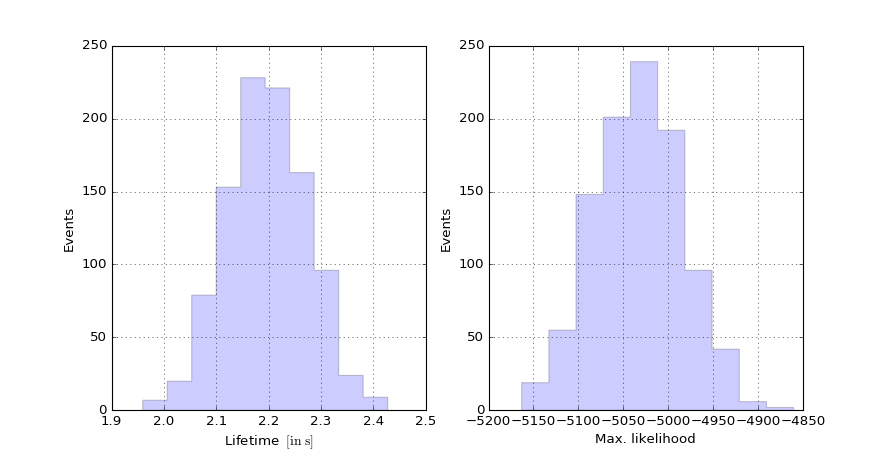

In [31]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(tau_fit, histtype='stepfilled', color='blue', alpha=0.2, label='histogram')
ax[1].hist(likhood, histtype='stepfilled', color='blue', alpha=0.2, label='histogram')
# plt.xlim(0, 20)
ax[0].set_xlabel(r'Lifetime $\; [ \mathrm{in \ s} ]$')
ax[0].set_ylabel(r'Events')
ax[1].set_xlabel(r'Max. likelihood')
ax[1].set_ylabel(r'Events')
#ax[0].set_suptitle('Best fit (lifetime)')
# plt.legend(loc='upper right', frameon=False)
ax[0].grid()
ax[1].grid()
plt.savefig(outfilepath + 'lifetime_fit.pdf')

## Method 2: Inverse cdf method 

In [ ]:
signal = []
cdf = (lambda t: (0.714/(1 - np.exp(-20/tau)))*(1 - np.exp(-t/tau)) + (0.286/20)*t)
icdf = inversefunc(cdf)
for i in range(sig_samples+bkg_samples):
	signal.append(icdf(np.random.random()))

events, bins = np.histogram(signal, 50) 
rescaled_bins = (bins[:-1] + bins[1:]) / 2  #rescaling bins to find midpoints for each bin

fig, ax = plt.subplots(1, 1)
plt.scatter(rescaled_bins, events)
plt.xlim(0, 20)
plt.xlabel(r'$t \; [ \mathrm{in \; s} ]$')
#plt.ylim(0, 16)
plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.ylabel(r'Events')
plt.grid()
plt.show()

As there is data available in every bin, we can minimize the chi-squared to obtain best fit parameters ($\,A, \tau$ and $B\,$) for the function,
\begin{equation}
f_\text{fit}(t) = A\,e^{\,(\frac{-t}{\tau})} \, + \, B
\end{equation}

where chi-squared is calculated the usual way,
\begin{equation}
\chi^2  = \sum_{i=1}^{N} \, \frac{(\, y_i - f_\text{fit}(t_i)\,)^2}{\sigma^2_{\text{th},\, i}}
\end{equation}

We use $\sigma_{\text{th},\, i} = \sqrt{f_\text{fit}(t_i)}$ instead of the experimental error to prevent the value of $\chi^2$ from blowing up for bins with no/very few events.

In [ ]:
init_params_chisq = [1, 1, 1]
def func_chisq(arg, A, lifetime, B):
	return (A*np.exp(-arg/lifetime) + B)
sigma = [np.sqrt(exp_func(rescaled_bins[i], tau)) for i in range(len(events))]
fit_param = curve_fit(func_chisq, rescaled_bins, events, init_params_chisq, sigma)[0]
print fit_param

chi_sq = np.sum([pow((events[i] - func_chisq(rescaled_bins[i], *fit_param)), 2)/pow(sigma[i], 2) for i in range(len(events))])
print (chi_sq/(len(rescaled_bins)-3))

In [ ]:
fig, ax = plt.subplots(1, 1)
plt.hist(signal, len(rescaled_bins), histtype='stepfilled', color='blue', alpha=0.2, label='histogram')
plt.plot(rescaled_bins, func_chisq(rescaled_bins, *fit_param), color='g', lw=2, label='pdf')
plt.xlim(0, 20)
plt.xlabel(r'$t \; [ \mathrm{in \ s} ]$')
plt.ylabel(r'Events')
plt.suptitle('Chi-square fit')
plt.legend(loc='upper right', frameon=False)
plt.grid()
plt.savefig(outfilepath + 'chisq_fit.pdf')